In [1]:
{
    "Coded by" : "Sairam H",
    "Email" : "26thofficial.creator@gmail.com",
    "LinkedIn" : "https://www.linkedin.com/sairam-h/",
    "Github" : "https://github.com/26th-Official/"
}

{'Coded by': 'Sairam H',
 'Email': '26thofficial.creator@gmail.com',
 'LinkedIn': 'https://www.linkedin.com/sairam-h/',
 'Github': 'https://github.com/26th-Official/'}

---
### THIS PROGRAM IS CODED WITH **PYTHON 3.8.x**, RUN IN THE SAME VERSION OR YOU WILL ENCOUNTER ERRORS
---

## Importing Necessary Libraries

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pickle
import random


from sklearn.preprocessing import OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score,mean_squared_error

from flaml import AutoML


from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import VotingRegressor


from hyperopt import hp,fmin, tpe, STATUS_OK, STATUS_FAIL, Trials,space_eval
from hyperopt.pyll.base import scope
from flaml import AutoML

## Loading the Dataset

In [3]:
train = pd.read_csv("./Data/train_BRCpofr.csv",index_col=False)
test = pd.read_csv("./Data/test_koRSKBP.csv",index_col=False)

## Data Preprocessing

In [4]:
def preprocess(inp):
    data = inp
    
    encoder = OrdinalEncoder()
    encoded_data = encoder.fit_transform(data[["gender","area","qualification","income","num_policies","policy","type_of_policy"]])
    data[["gender","area","qualification","income","num_policies","policy","type_of_policy"]] = pd.DataFrame(encoded_data.astype("int32"))
    
    imputer = SimpleImputer(strategy="most_frequent")
    imputed_data = imputer.fit_transform(data[["gender","area","qualification","income","marital_status","vintage","claim_amount","num_policies","policy","type_of_policy"]])
    data[["gender","area","qualification","income","marital_status","vintage","claim_amount","num_policies","policy","type_of_policy"]] = imputed_data
    
    # Feature Added after Data Analysis
    
    data["claim_prob"] = 0
    for i in range(len(data["claim_amount"])):
        if ((data["area"].loc[i] == 1) and (data["num_policies"].loc[i] == 1)):
            data["claim_prob"].loc[i] = 1
        else:
            data["claim_prob"].loc[i] = 0
                      
    try:
        x = data.drop("cltv",axis=1)
        y = data["cltv"]
    except:
        return data
    
    return x,y

In [5]:
x_train,y_train = preprocess(train)

## Data Analysis

In [6]:
print(train.shape)
print(train.isnull().values.any(),test.isnull().values.any())
train.head()

(89392, 13)
False False


,id,gender,area,qualification,income,marital_status,vintage,claim_amount,num_policies,policy,type_of_policy,cltv,claim_prob
0,1,1,1,0,1,1,5,5790,1,0,1,64308,1
1,2,1,0,1,1,0,8,5080,1,0,1,515400,0
2,3,1,1,0,1,1,8,2599,1,0,1,64212,1
3,4,0,0,1,1,0,7,0,1,0,1,97920,0
4,5,1,1,1,3,1,6,3508,1,0,0,59736,1


In [7]:
print(train.info())

print("==============================")

# Unique data in each Columns

for i in ["gender","area","qualification","income","num_policies","policy","type_of_policy"]:
    print(i,train[i].unique())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89392 entries, 0 to 89391
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   id              89392 non-null  int64
 1   gender          89392 non-null  int64
 2   area            89392 non-null  int64
 3   qualification   89392 non-null  int64
 4   income          89392 non-null  int64
 5   marital_status  89392 non-null  int64
 6   vintage         89392 non-null  int64
 7   claim_amount    89392 non-null  int64
 8   num_policies    89392 non-null  int64
 9   policy          89392 non-null  int64
 10  type_of_policy  89392 non-null  int64
 11  cltv            89392 non-null  int64
 12  claim_prob      89392 non-null  int64
dtypes: int64(13)
memory usage: 8.9 MB
None
gender [1 0]
area [1 0]
qualification [0 1 2]
income [1 3 0 2]
num_policies [1 0]
policy [0 2 1]
type_of_policy [1 0 2]


In [8]:
# Check for Data correlation

x_train.corrwith(train["cltv"]).sort_values()

marital_status   -0.077744
income           -0.060024
type_of_policy   -0.026221
qualification    -0.021330
policy           -0.012005
id               -0.004223
gender           -0.001318
vintage           0.020608
area              0.133107
claim_amount      0.180344
claim_prob        0.328011
num_policies      0.360414
dtype: float64

,gender,area,qualification,income,marital_status,vintage,claim_amount,num_policies,policy,type_of_policy,cltv,claim_prob
gender,1.000000,0.042516,-0.033076,-0.008311,0.070468,0.005827,0.049773,-0.052871,0.009049,-0.010702,-0.001318,-0.005363
area,0.042516,1.000000,0.022908,-0.203315,-0.048739,0.001145,0.451054,0.121898,-0.107123,-0.027672,0.133107,0.653088
qualification,-0.033076,0.022908,1.000000,0.001744,-0.012618,-0.027283,0.027440,-0.045894,-0.012722,-0.031595,-0.021330,-0.009550
income,-0.008311,-0.203315,0.001744,1.000000,0.015400,-0.011943,-0.153684,-0.047446,-0.033050,-0.025243,-0.060024,-0.148758
marital_status,0.070468,-0.048739,-0.012618,0.015400,1.000000,-0.011686,-0.114924,-0.082363,-0.014709,-0.006371,-0.077744,-0.086355
vintage,0.005827,0.001145,-0.027283,-0.011943,-0.011686,1.000000,0.009579,0.050699,0.043822,0.009025,0.020608,0.033352
claim_amount,0.049773,0.451054,0.027440,-0.153684,-0.114924,0.009579,1.000000,0.155281,-0.106845,-0.021854,0.180344,0.361017
num_policies,-0.052871,0.121898,-0.045894,-0.047446,-0.082363,0.050699,0.155281,1.000000,-0.009837,-0.033620,0.360414,0.691382
policy,0.009049,-0.107123,-0.012722,-0.033050,-0.014709,0.043822,-0.106845,-0.009837,1.000000,0.066279,-0.012005,-0.065660
type_of_policy,-0.010702,-0.027672,-0.031595,-0.025243,-0.006371,0.009025,-0.021854,-0.033620,0.066279,1.000000,-0.026221,-0.032400


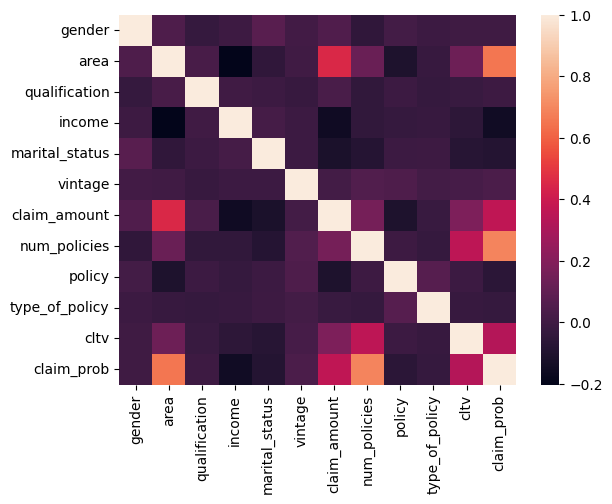

In [9]:
# Corellation Heatmap

plt.figure()
sns.heatmap(train.drop("id",axis=1).corr())

train.drop("id",axis=1).corr()

## Data Splitting 

In [10]:
x_train,x_val,y_train,y_val = train_test_split(x_train,y_train,test_size=0.05,random_state=42)
print([i.shape for i in [x_train,x_val,y_train,y_val]])

[(84922, 12), (4470, 12), (84922,), (4470,)]


## Hyper Parameter Tuning

In [11]:
# xgb_reg_params = {
#     'learning_rate':    hp.choice('learning_rate',    np.array([0.01, 0.1, 0.2, 0.3])),
#     'max_depth':        hp.choice('max_depth',        np.array([3, 5, 6, 10, 15, 20])),
#     'min_child_weight': hp.choice('min_child_weight', np.arange(1, 8, 1, dtype=int)),
#     'colsample_bytree': hp.choice('colsample_bytree', np.arange(0.4, 1.0, 0.1)),
#     'colsample_bylevel': hp.choice('colsample_bylevel', np.arange(0.4, 1.0, 0.1)),
#     'subsample':        hp.choice('subsample', np.arange(0.5, 1.0, 0.1)),
#     'n_estimators':     hp.choice('n_estimators', np.arange(200, 1200, 200)),
# }


# LGBM_Param = {
#         "n_estimators": hp.choice("n_estimators", np.arange(100,2000,100)),
#         "learning_rate": hp.choice("learning_rate", np.arange(0.01,0.3,0.1)),
#         "num_leaves": hp.choice("num_leaves", np.arange(20,4000,20)),
#         "max_depth": hp.choice("max_depth",np.arange(3, 12, 1)),
#         "min_data_in_leaf": hp.choice("min_data_in_leaf", np.arange(200, 1000, 200)),
#         # "lambda_l1": hp.choice("lambda_l1", np.arange(0,100,10)),
#         # "lambda_l2": hp.choice("lambda_l2", np.arange(0,100,10)),
#         "min_gain_to_split": hp.choice("min_gain_to_split", np.arange(0,15,1)),
#         "bagging_fraction": hp.choice("bagging_fraction",np.arange(0.2, 0.9,0.1)),
#         # "bagging_freq": hp.choice("bagging_freq", [1]),
#         "feature_fraction": hp.choice("feature_fraction",np.arange(0.2, 0.9,0.1)),
#     }


# cat_Param = {
#     'depth': hp.choice("depth",np.arange(4,10,1)),
#     'learning_rate' : hp.choice("learning_rate",[0.01, 0.05, 0.1]),
#     'iterations': hp.choice("iterations",[30, 50,100,130,150,180,200])
# }  

In [12]:
# def hypertuner(parameter):
#     model = CatBoostRegressor(**parameter)
#     model.fit(x_train.drop("id",axis=1).loc[:30000],y_train.loc[:30000])
#     pred = model.predict(x_val.drop("id",axis=1))
#     score = r2_score(y_val,pred)
    
#     print (f"r2_score: {score}")
#     return {"loss": -score, "status": STATUS_OK}

In [13]:
# best_parameters = fmin(
#     fn = hypertuner,
#     space = cat_Param,
#     algo = tpe.suggest,
#     max_evals=200,
#     trials=Trials()
# )

# print("Best: {}".format(best_parameters))
# print(space_eval(cat_Param, best_parameters))

## Fine-Tune Hyper Parameters

In [14]:
# model = AutoML()
# automl_settings = {
#     "time_budget": 500, 
#     "metric": 'r2',
#     "task": 'regression',
#     "estimator_list": ["xgboost"],
#     "starting_points": space_eval(xgb_reg_params, best_parameters)
# }

In [15]:
# model.fit(x_train.drop("id",axis=1),y_train)

In [16]:
# print('Best ML leaner:', model.best_estimator)
# print('Best hyperparmeter config:', model.best_config)
# print('Best accuracy on validation data: {0:.4g}'.format(1-model.best_loss))
# print('Training duration of best run: {0:.4g} s'.format(model.best_config_train_time))

# # Saving the model - 

# pickle.dump(model4,open("XGB_Model.sav","wb"))

## Using Voting Regressor

In [17]:
# Saved Models from Fine Tuning

model1 = pickle.load(open("./XGB_Model.sav","rb"))
model3 = pickle.load(open("./CATB_Model.sav","rb"))
model2 = pickle.load(open("./LGBM_Model.sav","rb"))
model4 = pickle.load(open("./XGB.sav","rb"))

In [18]:
voter = VotingRegressor([
    ("XGB", model1),
    ("LGBM", model2),
    ("CAT", model3)
])

voter.estimators_ = [model1,model2,model3]

model = VotingRegressor([
    ("V1", voter),
    ("AML", model4),
])

model.estimators_ = [voter,model4]

## Test Data Prediction

In [19]:
def prediction(x_data,y_data):
    pred = model.predict(x_data.drop("id",axis=1))
    score = r2_score(y_data,pred)
    
    print(f"r2_Score - {score}")
    
    return pred


In [20]:
print(prediction(x_val,y_val))

r2_Score - 0.1585933399559185
[110371.82250618  50947.73407877  47204.04664961 ...  53346.8192343
  97295.53150886  56612.61644021]


In [21]:
x_test = preprocess(test)
t_pred = model.predict(x_test.drop("id",axis=1))

print(t_pred)

[ 92612.98357842 131935.58733926  96539.01161022 ... 107596.20682154
 103625.23685706 115321.62486728]


## Submission

In [22]:
id = x_test["id"]
id.reset_index(drop=True, inplace=True)

t_pred = pd.DataFrame(t_pred,columns=["cltv"])
t_pred.reset_index(drop=True, inplace=True)

In [23]:
submission = pd.concat([id,t_pred],axis=1)
submission.to_csv("submission.csv",index=False)